In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid and space SEPP

We use a grid based histogram to estimate the background rate, but a "full" trigger.  Here we drop the Gaussian decay, so in space, the trigger is just uniform in a disc.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import open_cp.data
import open_cp.sources.sepp as source_sepp
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout("open_cp")
import sepp.sepp_grid
import sepp.sepp_grid_space

## The background sampler we'll use

In [3]:
class GridPoissonSampler(source_sepp.Sampler):
    def __init__(self, grid, rates, clustered=False):
        self._grid = grid
        self._rates = np.asarray(rates)
        assert (grid.yextent, grid.yextent) == self._rates.shape
        self._clustered = clustered
    
    def sample(self, start_time, end_time):
        points = []
        dt = end_time - start_time
        event_counts = np.random.poisson(dt * self._rates)
        for i in range(event_counts.shape[0]):
            for j in range(event_counts.shape[1]):
                times = np.random.random(event_counts[i,j]) * dt + start_time
                if self._clustered:
                    xcs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.xsize
                    ycs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.ysize
                else:
                    xcs = np.random.random(event_counts[i,j]) * self._grid.xsize
                    ycs = np.random.random(event_counts[i,j]) * self._grid.ysize
                xcs += self._grid.xoffset + j * self._grid.xsize
                ycs += self._grid.yoffset + i * self._grid.ysize
                for t, x, y in zip(times, xcs, ycs):
                    points.append([t,x,y])
        points = np.asarray(points).T
        return self._order_by_time(points)
    
class DiscRegionSampler(source_sepp.SpaceSampler):
    def __init__(self, radius):
        self._r = radius
        
    def __call__(self, length):
        x, y = [], []
        rr = self._r ** 2
        while len(x) < length:
            xc, yc = np.random.random(2) * 2 * self._r - self._r
            if xc*xc + yc*yc < rr:
                x.append(xc)
                y.append(yc)
        
        return np.vstack([x,y])

In [4]:
grid = sepp.sepp_grid.ConcreteBoundedGrid(50, 50, 0, 0, 10, 10)
rates = np.random.random(size=(10,10)) / 10
bk_sampler = GridPoissonSampler(grid, rates, clustered=False)
tr_sampler = source_sepp.InhomogeneousPoissonFactors(source_sepp.Exponential(10, 0.5),
                DiscRegionSampler(2))
simulate = source_sepp.SelfExcitingPointProcess(bk_sampler, tr_sampler)

In [5]:
details = simulate.sample_with_details(0, 365)

## Triggering

Seems exponential in time and uniformly in a disc in space, as expected

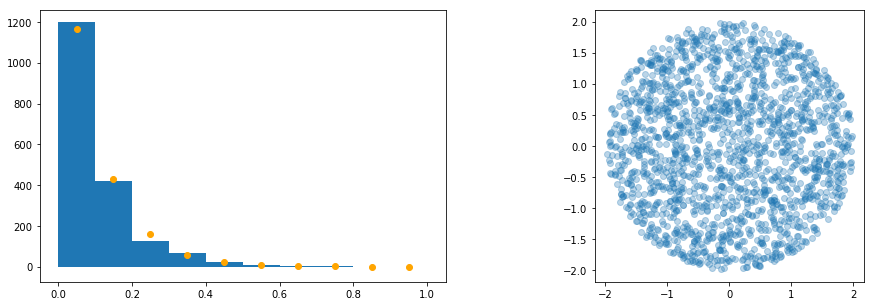

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

axes[0].hist(details.trigger_deltas[0], bins=np.linspace(0,1,11))
x = np.linspace(0,1,11)
y = details.trigger_deltas.shape[1] * (np.exp(-10*x)[:-1] - np.exp(-10*x)[1:])
x += (x[1] - x[0])/2
axes[0].scatter(x[:-1], y, color="orange", zorder=10)
axes[1].scatter(*details.trigger_deltas[1:,], alpha=0.3)
axes[1].set_aspect(1)
None

In [7]:
print("Estimated omega =",
    1 / np.mean(details.trigger_deltas[0]) )

Estimated omega = 10.3540543558


## Background

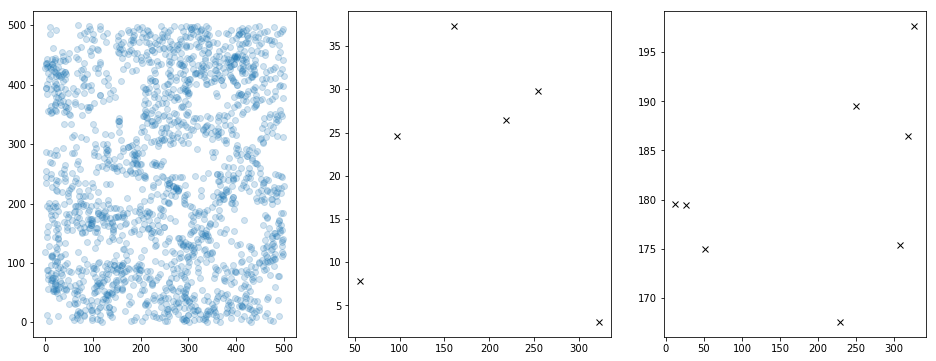

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))

xcs = details.backgrounds[1]
ycs = details.backgrounds[2]
axes[0].scatter(xcs, ycs, alpha=0.2)

m = (xcs < 50) & (ycs < 50)
times = details.backgrounds[0][m]
axes[1].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

m = (xcs > 150) & (xcs < 200) & (ycs < 50)
times = details.backgrounds[0][m]
axes[2].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

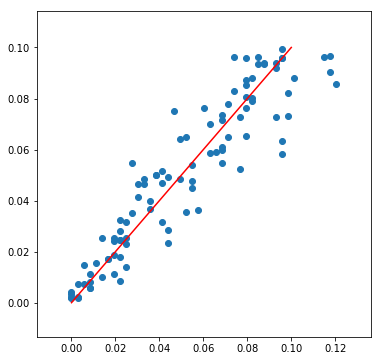

In [9]:
xg = np.floor(details.backgrounds[1] / 50).astype(np.int)
yg = np.floor(details.backgrounds[2] / 50).astype(np.int)
mu = np.zeros_like(rates)
for x, y in zip(xg, yg):
    mu[y,x] += 1
mu /= 365
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(mu.flatten(), rates.flatten())
ax.plot([0,0.1], [0,0.1], color="red")
None

## Combined

In [10]:
points = details.points

m = (points[1] >= 0) & (points[1] < 500) & (points[2] >= 0) & (points[2] < 500)
points = points[:,m]
points.shape, details.points.shape

((3, 3710), (3, 3715))

In [11]:
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1),
    time_unit)
timed_points.time_range

(numpy.datetime64('2017-01-02T06:49:35.513'),
 numpy.datetime64('2017-12-31T23:05:28.478'))

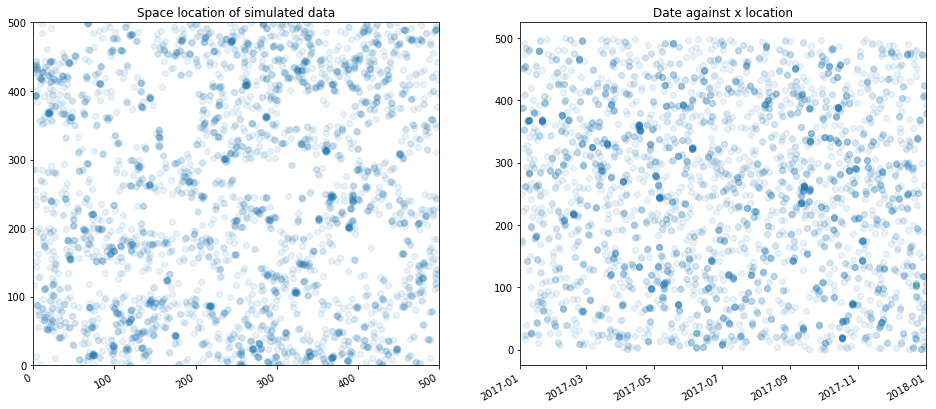

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.1)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,500], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.1)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

# Fit

- Works well.
- If we set $r_0$ too small, then overestimates background
- If we set $r_0$ too large, it still copes fairly well

In [13]:
trainer = sepp.sepp_grid_space.Trainer2(grid, 2)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), iterations=1)

In [14]:
model

Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.497767950716861, omega=7.980789054393857, r0=2

In [15]:
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(20):
    opt = sepp.sepp_grid_space.Optimiser2(model, data)
    model = opt.iterate()
    print(model)

Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.497767950716861, omega=7.980789054393857, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.496256797473017, omega=10.170885616127832, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961659579025611, omega=10.45427888048337, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961502684196364, omega=10.486357596558818, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961483963565024, omega=10.48993449572795, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961481862297083, omega=10.490332678562863, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961

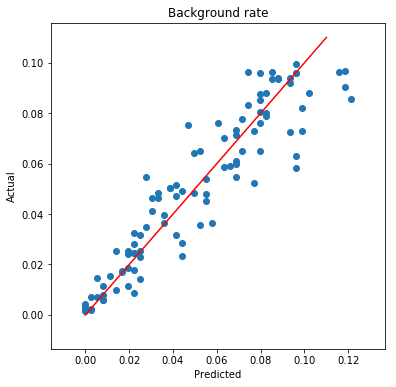

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")
None

# Histogram model

In [17]:
trainer = sepp.sepp_grid_space.Trainer3(grid, 2, bandwidth=0.05)
trainer.data = timed_points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(20):
    opt = sepp.sepp_grid_space.Optimiser3(model, data)
    model = opt.iterate()
    print(model)

Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4918776436609321, bandwidth=0.05, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49599654045938596, bandwidth=0.05, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49617857142693333, bandwidth=0.05, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961876439318891, bandwidth=0.05, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49618870720547925, bandwidth=0.05, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961888724064121, bandwidth=0.05, r0=2
Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4961889051249372, bandwidth=0.05, r0=2
Model2(mu size=(1

In [18]:
def plot(model):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    ax = axes[0]
    ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
    ax.plot([0,0.11], [0,0.11], color="red")
    ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")

    ax = axes[1]
    x = np.arange(20) * model.bandwidth
    ax.bar(x + model.bandwidth/2, model.alpha_array[:len(x)] * model.theta,
           model.bandwidth, color="none", edgecolor="black")
    y = np.exp(-10*x[:-1]) - np.exp(-10*x[1:])
    ax.scatter((x[:-1]+x[1:])/2, y * 0.5)
    None

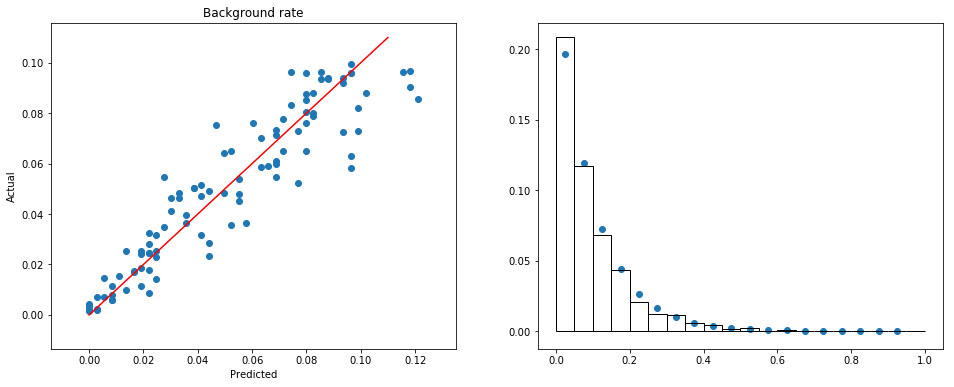

In [19]:
plot(model)

In [20]:
trainer = sepp.sepp_grid_space.Trainer3(grid, 2, bandwidth=0.1)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), 20)
model

Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49666828272115066, bandwidth=0.1, r0=2

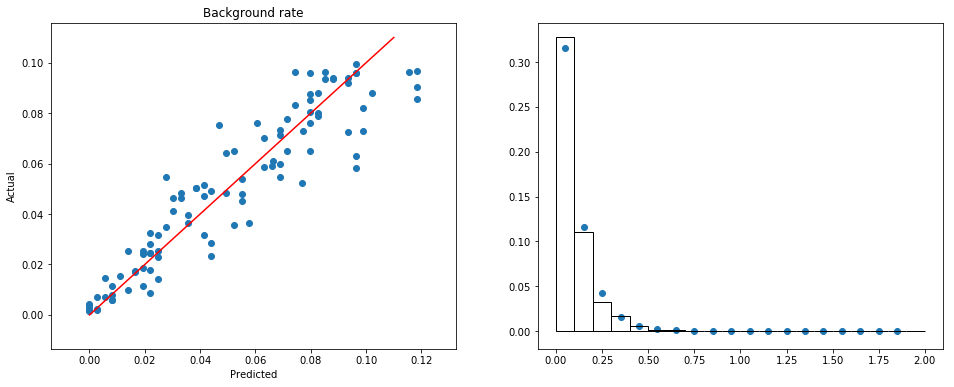

In [21]:
plot(model)

In [22]:
trainer = sepp.sepp_grid_space.Trainer3(grid, 2, bandwidth=0.01)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), 20)
model

Model2(mu size=(10, 10), T=363.71556119212966, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4862515438189099, bandwidth=0.01, r0=2

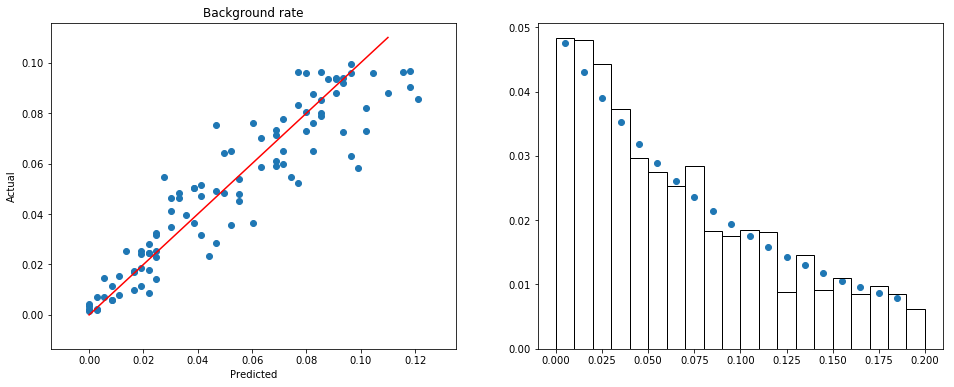

In [23]:
plot(model)